# SQAE with DRC 

Quantum autoencoder on larger MNIST images by encoding the high dimensional data using DRC

### imports 

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pennylane.optimize import AdamOptimizer
from models.quantum import qae_constrastive

import warnings
warnings.filterwarnings('ignore')

2024-06-15 21:28:18.310801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-15 21:28:18.310852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### settings

First fix some settings:

- INPUT_DATA_SIZE: The size the images will be scaled to (e.g. 12x12)  
- DRCs: The number of data reuploads in the encoder
- EPOCHS: number of epochs to train
- LATENT_QBITS: Number qbits in the latent space
- DATA_QBITS: number of qubits to use for the encoder

In [2]:
INPUT_DATA_SIZE = 12

DRCs = 1
EPOCHS = 4

DATA_QBITS = 9
LATENT_QBITS = 5
AUX_QBITS = 3

TOTAL_QBITS = DATA_QBITS * 2 + AUX_QBITS

### data 

We download MNIST as example images and normalize them

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

For a simple anomaly tagging setting, we filter out only threes and sixes.
We split them into seperate datasets.

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

In [5]:
x_train_threes = np.array(x_train[y_train==True])
x_train = np.array(x_train[y_train==False])

x_test_threes = np.array(x_test[y_test==True])
x_test = np.array(x_test[y_test==False])

Reshape for tf.image and scale down

In [6]:
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_train_threes = x_train_threes.reshape(x_train_threes.shape + (1,))
x_test_threes = x_test_threes.reshape(x_test_threes.shape + (1,))

In [7]:
x_train_small = tf.image.resize(x_train, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_small = tf.image.resize(x_test, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

x_train_3_small = tf.image.resize(x_train_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()
x_test_3_small = tf.image.resize(x_test_threes, (INPUT_DATA_SIZE,INPUT_DATA_SIZE), method="lanczos5").numpy()

2024-06-15 21:28:21.733449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-15 21:28:21.733724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-15 21:28:21.733822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-06-15 21:28:21.733935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-06-15 21:28:21.734023: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Two example images from the different classes

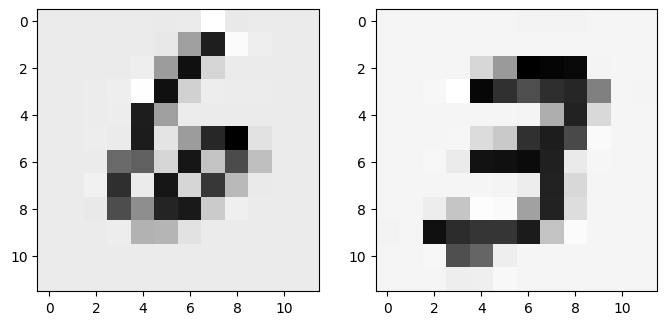

In [8]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].imshow(x_train_small[0], cmap='binary')
axs[1].imshow(x_train_3_small[0], cmap='binary')

drop last dimension as its (1,)

In [9]:
x_train_small = x_train_small.reshape(x_train_small.shape[:-1])
x_test_small = x_test_small.reshape(x_test_small.shape[:-1])

x_train_3_small = x_train_3_small.reshape(x_train_3_small.shape[:-1])
x_test_3_small = x_test_3_small.reshape(x_test_3_small.shape[:-1])

reduce the size of the data for faster training:

In [10]:
x_train_small = x_train_small[:1000]
x_train_3_small = x_train_3_small[:1000]
x_test_small = x_test_small[:300]
x_test_3_small = x_test_3_small[:300]

Now we have the following datasets:

In [11]:
print("x_train_small: ", x_train_small.shape)
print("x_test_small: ", x_test_small.shape)
print("x_train_3_small: ", x_train_3_small.shape)
print("x_test_3_small: ", x_test_3_small.shape)

x_train_small:  (1000, 12, 12)
x_test_small:  (300, 12, 12)
x_train_3_small:  (1000, 12, 12)
x_test_3_small:  (300, 12, 12)


## Circuit

Create pennylane device to simulate on. For cpu best fastest is lightning.qubit

In [12]:
dev1 = qml.device('lightning.qubit', wires=TOTAL_QBITS)

Create SQAE model.
Since the input images are 12x12 we split it into 9 4x4 patches. Therfore we use 9 data qubits with kernel_size 4 and stride 4.
The fastest diff method for simulation is adjoint

In [13]:

model = qae_constrastive.ContrastiveConvEncoderCircuit(DATA_QBITS,
                      LATENT_QBITS,
                      AUX_QBITS,
                      dev1, 
                      INPUT_DATA_SIZE, 
                      kernel_size=4, 
                      stride=4, 
                      DRCs=DRCs)


plot the circuit to check

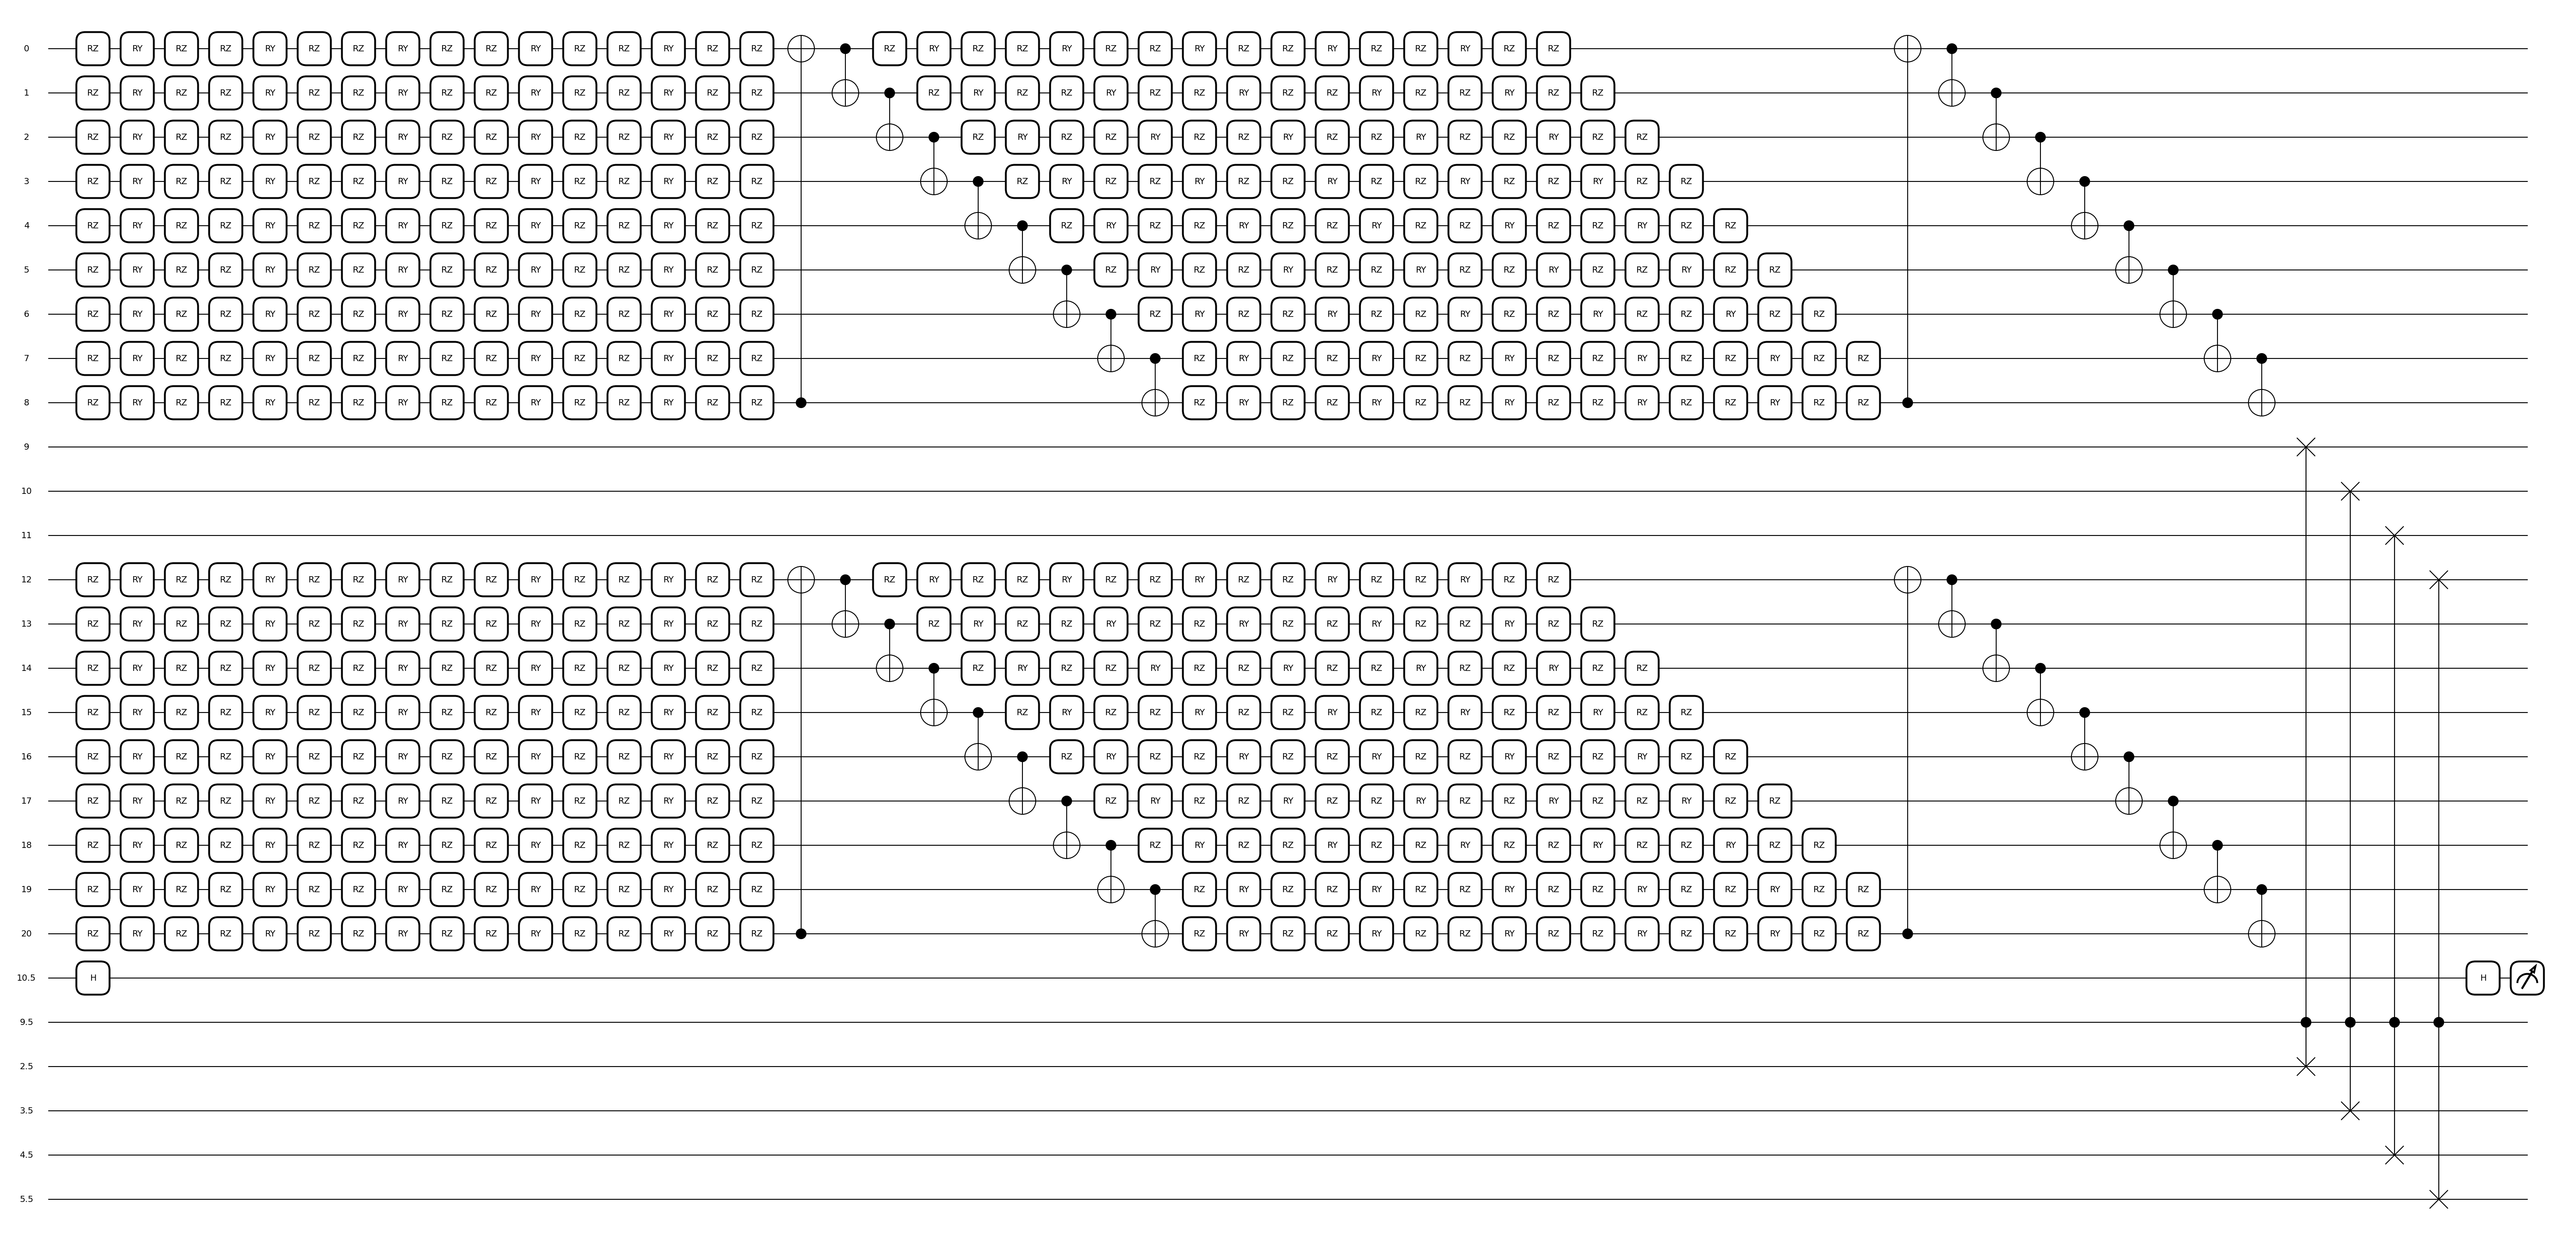

In [14]:
model.plot_circuit()

Train the model on the threes. Print step size gives the step interval to print loss and record the auc on tagging sixes with x_val_signa.

In [15]:

# from torch.utils.data import DataLoader, TensorDataset, random_split

# train_loader = DataLoader(x_train_3_small, batch_size=8, shuffle=True)
# val_loader = DataLoader(x_test_3_small, batch_size=8)

# import pytorch_lightning as pl
# from pytorch_lightning.loggers import CSVLogger

# dev = qml.device('default.qubit', wires=8)
# # model = ConvSQAE(data_qbits=8, latent_qbits=4, device=dev, img_dim=8, kernel_size=3, stride=1, DRCs=1, learning_rate=0.01)

# logger = CSVLogger(save_dir="logs/", name="quantum_autoencoder")
# trainer = pl.Trainer(max_epochs=3, logger=logger, gpus=0)
# trainer.fit(model, train_loader, val_loader)